In [1]:
import pandas as pd

In [2]:
df1 = pd.read_excel('ts.xlsx', engine='openpyxl')
df1 = df1.reset_index(drop=True)
df1 = df1[['date', 'avg_sqm_price',	'record_count',	'avg_usd',	'key_rate',	'inflation_rate']]


WINDOW_SIZE=6, LSTM units=32, batch_size=16, optimizer=adam
minimal loss on validation: 0.01656

WINDOW_SIZE=6, LSTM units=32, batch_size=16, optimizer=rmsprop
minimal loss on validation: 0.02512

WINDOW_SIZE=6, LSTM units=32, batch_size=32, optimizer=adam
minimal loss on validation: 0.01501

WINDOW_SIZE=6, LSTM units=32, batch_size=32, optimizer=rmsprop
minimal loss on validation: 0.01113

WINDOW_SIZE=6, LSTM units=64, batch_size=16, optimizer=adam
minimal loss on validation: 0.00598

WINDOW_SIZE=6, LSTM units=64, batch_size=16, optimizer=rmsprop
minimal loss on validation: 0.01194

WINDOW_SIZE=6, LSTM units=64, batch_size=32, optimizer=adam
minimal loss on validation: 0.00560

WINDOW_SIZE=6, LSTM units=64, batch_size=32, optimizer=rmsprop
minimal loss on validation: 0.01056

WINDOW_SIZE=6, LSTM units=128, batch_size=16, optimizer=adam
minimal loss on validation: 0.00776

WINDOW_SIZE=6, LSTM units=128, batch_size=16, optimizer=rmsprop
minimal loss on validation: 0.01250

WINDOW_SIZE=

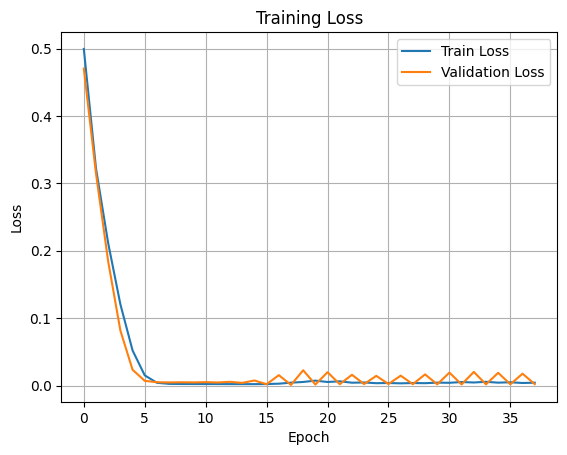

1/1 [==============================] - 0s 283ms/step


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

FEATURES = ['avg_sqm_price', 'record_count', 'avg_usd', 'key_rate', 'inflation_rate']
TARGET_IDX = 0

df = df1.copy()
df = df.sort_values('date')
df = df.set_index('date')

# fixed forecast horizon
FORECAST_HORIZON = 5

# params for search
window_size_options = [6, 12, 18]
lstm_units_options = [32, 64, 128]
batch_size_options = [16, 32]
optimizer_options = ['adam', 'rmsprop']

best_val_loss = np.inf
best_params = {}
best_model = None
best_history = None
best_X_test, best_y_test = None, None
best_scaler = None

for WINDOW_SIZE in window_size_options:
    # preprocessing
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[FEATURES])

    X, y = [], []
    for i in range(WINDOW_SIZE, len(scaled) - FORECAST_HORIZON + 1):
        X.append(scaled[i - WINDOW_SIZE:i])
        y.append([scaled[i + j][TARGET_IDX] for j in range(FORECAST_HORIZON)])
    X = np.array(X)
    y = np.array(y)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    for lstm_units in lstm_units_options:
        for batch_size in batch_size_options:
            for optimizer_name in optimizer_options:
                print(f"\nWINDOW_SIZE={WINDOW_SIZE}, LSTM units={lstm_units}, batch_size={batch_size}, optimizer={optimizer_name}")

                model = Sequential()
                model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
                model.add(Dense(FORECAST_HORIZON))
                model.compile(optimizer=optimizer_name, loss='mse')

                early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)

                history = model.fit(
                    X_train, y_train,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=0
                )

                min_val_loss = min(history.history['val_loss'])
                print(f"minimal loss on validation: {min_val_loss:.5f}")

                if min_val_loss < best_val_loss:
                    best_val_loss = min_val_loss
                    best_params = {
                        'WINDOW_SIZE': WINDOW_SIZE,
                        'FORECAST_HORIZON': FORECAST_HORIZON,
                        'lstm_units': lstm_units,
                        'batch_size': batch_size,
                        'optimizer': optimizer_name
                    }
                    best_model = model
                    best_history = history
                    best_X_test = X_test
                    best_y_test = y_test
                    best_scaler = scaler

print(f"\nBest parameters: {best_params}, minimal loss on validation: {best_val_loss:.5f}")

# loss function visualiztion
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.grid(True)
plt.show()

# best models prediction
y_pred = best_model.predict(best_X_test)

# inverse transform (only price)
def inverse_transform(y_scaled, scaler, target_idx=0):
    temp = np.zeros((len(y_scaled), len(FEATURES)))
    temp[:, target_idx] = y_scaled
    return scaler.inverse_transform(temp)[:, target_idx]

y_pred_real = inverse_transform(y_pred.flatten(), best_scaler).reshape(-1, FORECAST_HORIZON)
y_test_real = inverse_transform(best_y_test.flatten(), best_scaler).reshape(-1, FORECAST_HORIZON)

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAPE calculation function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # to avoid division by 0
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100


y_test_flat = y_test_real.flatten()
y_pred_flat = y_pred_real.flatten()

mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 1238.8295
MAPE: 0.34%
MSE: 2329657.5660
RMSE: 1526.3216


In [5]:
last_window = best_scaler.transform(df[FEATURES])[-best_params['WINDOW_SIZE']:]

last_window_input = np.expand_dims(last_window, axis=0)

future_pred_scaled = best_model.predict(last_window_input)  # (1, FORECAST_HORIZON)

def inverse_transform_single(y_scaled, scaler, target_idx=0):
    temp = np.zeros((len(y_scaled), len(FEATURES)))
    temp[:, target_idx] = y_scaled
    return scaler.inverse_transform(temp)[:, target_idx]

future_pred_real = inverse_transform_single(future_pred_scaled.flatten(), best_scaler)

print("The forecast of avg_sqm_price for the next 5 months:")
for i, val in enumerate(future_pred_real, 1):
    print(f"Month +{i}: {val:.2f}")

1/1 [==============================] - 0s 14ms/step
The forecast of avg_sqm_price for the next 5 months:
Month +1: 367279.78
Month +2: 367653.17
Month +3: 370024.99
Month +4: 374782.12
Month +5: 378513.32


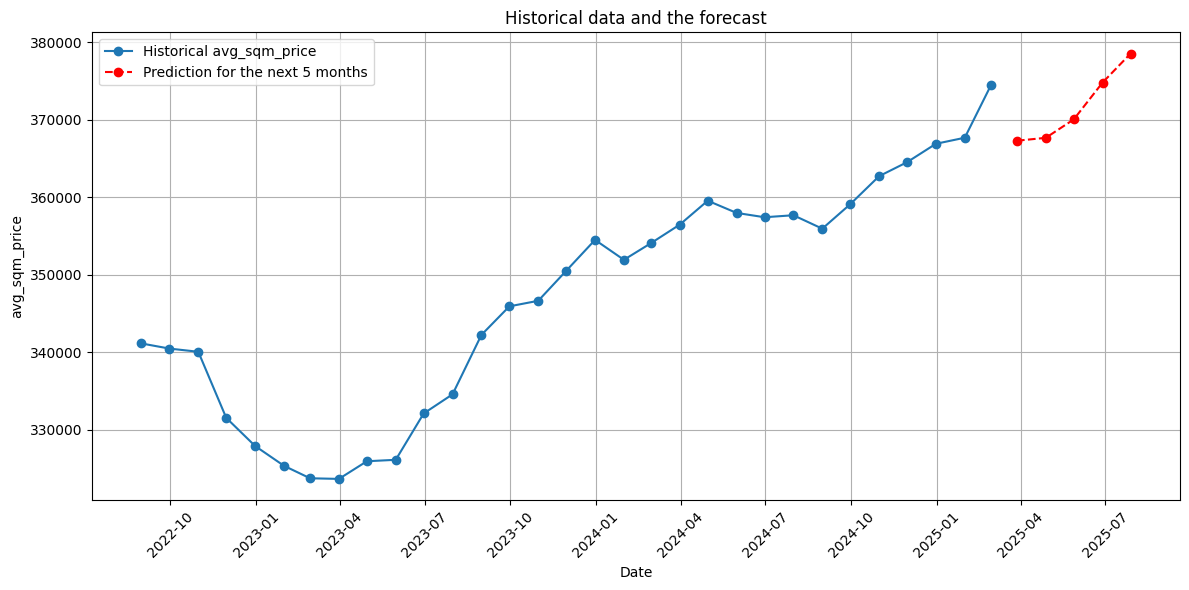

In [6]:
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset


all_scaled = best_scaler.transform(df[FEATURES])
all_avg_sqm_price = inverse_transform(all_scaled[:, TARGET_IDX], best_scaler)


dates = df.index


last_date = dates[-1]
future_dates = [last_date + DateOffset(months=i) for i in range(1, FORECAST_HORIZON + 1)]

# plot
plt.figure(figsize=(12, 6))
plt.plot(dates, all_avg_sqm_price, label='Historical avg_sqm_price', marker='o')
plt.plot(future_dates, future_pred_real, label='Prediction for the next 5 months', marker='o', linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('avg_sqm_price')
plt.title('Historical data and the forecast')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()